# REINFORCE

a.k.a. Vanilla Policy Gradient

Algorithm:

```py
# initialize theta (net) & b (baseline)
init(net, b)
for iteration in (1, 2, ...):
    trajectory = env.play(net)
    R = 0
    mse = 0
    for t, (s, a, r) in enumerate(trajectory[::-1]):
        R += r
        # calc policy gradients
        A = R - b(s)
        log_prob = log(net(s)[a]) # pi(a|s)
        log_prob.backward() # calc gradients
        # calc baseline loss
        b_mse += (b(s) - R) ** 2
        R *= gamma
    minimize(b_mse)
    net.step() # update accumulated gradients
```

In [1]:
%matplotlib inline
import collections
import random
import gym
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v0')

In [3]:
SEED = 4
env.seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
env.observation_space

Box(4,)

In [5]:
env.action_space

Discrete(2)

In [6]:
class DQN(nn.Module):
    def __init__(self, n_obs, n_action, n_hidden=64):
        """ 2-hidden layer NN
        n_obs: # of observations
        n_action: # of actions
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_obs, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_action)
        )
    
    def forward(self, x):
        return self.net(x)
    
    def act(self, x):
        return torch.argmax(self.forward(x)).item()

In [7]:
class ReplayMemory(collections.deque):
    def __init__(self, maxlen, device):
        super().__init__(maxlen=maxlen)
        self.device = device
    
    def sample(self, size):
        # state, action, reward, next_state, done
        sarsd_list = zip(*random.sample(self, size))
        return list(map(lambda x: torch.FloatTensor(x).to(device), sarsd_list))

In [8]:
observation = env.reset()

In [9]:
observation

array([ 0.02543978,  0.02580473, -0.00815877,  0.01237681])

In [10]:
def calc_td_error(memory, batch_size, gamma):
    # calc td error
    state, action, reward, next_state, done = memory.sample(batch_size)
    cur_Q = net(state).gather(dim=1, index=action.long().unsqueeze(1)).squeeze()
    next_Q = net(next_state).max(dim=1)[0] # if done, next_q should be 0.
    # stop gradient to next_Q
    next_Q = next_Q.detach() * (1-done)
    td_error = (reward + gamma * next_Q) - cur_Q
    
    return td_error

In [19]:
n_episode = 500
eps = 1.0
eps_min = 0.001
eps_decay = 0.997
batch_size = 64
gamma = 0.99 # discount factor
memory_size = 1000
device = torch.device("cuda")

memory = ReplayMemory(maxlen=memory_size, device=device)
net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

losses = []
rewards = []

for episode in range(n_episode):
    state = env.reset()
    done = False
    t = 0
    total_reward = 0
    while not done:
        t += 1
        if np.random.rand() <= eps:
            # random move
            action = env.action_space.sample()
        else:
            action = net.act(torch.FloatTensor(state).to(device))
        
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        
        memory.append((state, action, reward, next_state, done))
        
        # training
        if len(memory) >= batch_size:
            td_error = calc_td_error(memory, batch_size, gamma)
#             loss = torch.mean(torch.abs(td_error))
            loss = torch.mean(td_error ** 2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
        
        # prepare next iteration
        state = next_state
        eps = max(eps * eps_decay, eps_min)
    
    print("[EP {:4d}] Done in Timestep {}. Reward = {}, Current epsilon = {}".format(episode, t+1, total_reward, eps))
    rewards.append(total_reward)

[EP    0] Done in Timestep 14. Reward = 13.0, Current epsilon = 0.9616943356035061
[EP    1] Done in Timestep 15. Reward = 14.0, Current epsilon = 0.9220814271464737
[EP    2] Done in Timestep 36. Reward = 35.0, Current epsilon = 0.8300415167526705
[EP    3] Done in Timestep 24. Reward = 23.0, Current epsilon = 0.7746195551602378
[EP    4] Done in Timestep 17. Reward = 16.0, Current epsilon = 0.7382628067611632
[EP    5] Done in Timestep 32. Reward = 31.0, Current epsilon = 0.6726062478080883
[EP    6] Done in Timestep 16. Reward = 15.0, Current epsilon = 0.6429663904714829
[EP    7] Done in Timestep 18. Reward = 17.0, Current epsilon = 0.6109504135464614
[EP    8] Done in Timestep 11. Reward = 10.0, Current epsilon = 0.5928673669331617
[EP    9] Done in Timestep 17. Reward = 16.0, Current epsilon = 0.5650411526967395
[EP   10] Done in Timestep 21. Reward = 20.0, Current epsilon = 0.5320877315740353
[EP   11] Done in Timestep 18. Reward = 17.0, Current epsilon = 0.5055928652970137
[EP 

[EP  107] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  108] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  109] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  110] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  111] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  112] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  113] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  114] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  115] Done in Timestep 79. Reward = 78.0, Current epsilon = 0.001
[EP  116] Done in Timestep 96. Reward = 95.0, Current epsilon = 0.001
[EP  117] Done in Timestep 10. Reward = 9.0, Current epsilon = 0.001
[EP  118] Done in Timestep 10. Reward = 9.0, Current epsilon = 0.001
[EP  119] Done in Timestep 11. Reward = 10.0, Current epsilon = 0.001
[EP  120] Done in Timestep 24. Reward = 23.0, Current epsilon = 0.001
[EP  1

[EP  224] Done in Timestep 57. Reward = 56.0, Current epsilon = 0.001
[EP  225] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  226] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  227] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  228] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  229] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  230] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  231] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  232] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  233] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  234] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  235] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  236] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  237] Done in Timestep 201. Reward = 200.0, Current epsilon = 

[EP  345] Done in Timestep 11. Reward = 10.0, Current epsilon = 0.001
[EP  346] Done in Timestep 11. Reward = 10.0, Current epsilon = 0.001
[EP  347] Done in Timestep 12. Reward = 11.0, Current epsilon = 0.001
[EP  348] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  349] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  350] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  351] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  352] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  353] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  354] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  355] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  356] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  357] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  358] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.00

[EP  470] Done in Timestep 10. Reward = 9.0, Current epsilon = 0.001
[EP  471] Done in Timestep 13. Reward = 12.0, Current epsilon = 0.001
[EP  472] Done in Timestep 13. Reward = 12.0, Current epsilon = 0.001
[EP  473] Done in Timestep 11. Reward = 10.0, Current epsilon = 0.001
[EP  474] Done in Timestep 16. Reward = 15.0, Current epsilon = 0.001
[EP  475] Done in Timestep 22. Reward = 21.0, Current epsilon = 0.001
[EP  476] Done in Timestep 177. Reward = 176.0, Current epsilon = 0.001
[EP  477] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  478] Done in Timestep 201. Reward = 200.0, Current epsilon = 0.001
[EP  479] Done in Timestep 165. Reward = 164.0, Current epsilon = 0.001
[EP  480] Done in Timestep 130. Reward = 129.0, Current epsilon = 0.001
[EP  481] Done in Timestep 121. Reward = 120.0, Current epsilon = 0.001
[EP  482] Done in Timestep 78. Reward = 77.0, Current epsilon = 0.001
[EP  483] Done in Timestep 64. Reward = 63.0, Current epsilon = 0.001
[EP  484]

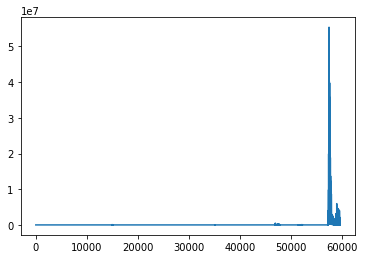

In [20]:
plt.plot(losses)

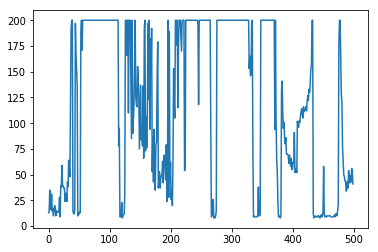

In [21]:
plt.plot(rewards)

In [14]:
ls = np.array(losses)

In [15]:
ls[ls > 10000]

array([1.11173652e+04, 1.00308457e+04, 1.07197900e+04, ...,
       1.23072781e+09, 1.23881242e+09, 1.26926938e+09])

In [16]:
td_error

tensor([  464020544.,   525897728.,   482445696.,   471271424.,   499907584.,
          494251776., -5248251392.,   490851456.,   534599936.,   508667648.,
          486620160.,   543759872.,   530984448.,   482119680.,   514008064.,
          500360448., -5847033856.,   550514688.,   494404096.,   483649152.,
          467017408.,   527798016.,   493265920.,   503575296.,   548934656.,
        -5728592896.,   509581568.,   464835776.,   474407424.,   521363712.,
          478313984.,   534998016.,   525963264.,   493194240.,   536891904.,
          479909120.,   488288768.,   532385280.,   483284416.,   469952384.,
          525641216., -5334137856.,   502676480.,   472593280.,   508629760.,
          500539648., -5783218688.,   478150912., -5342231552.,   504084224.,
          511115264.,   491522304.,   483213056., -4937254912., -5260265472.,
          503189504.,   466272896.,   539664384., -5464582144., -5232053248.,
          477940160.,   478162688.,   547303936.,   472629056.],

In [17]:
torch.abs(td_error)

tensor([ 464020544.,  525897728.,  482445696.,  471271424.,  499907584.,
         494251776., 5248251392.,  490851456.,  534599936.,  508667648.,
         486620160.,  543759872.,  530984448.,  482119680.,  514008064.,
         500360448., 5847033856.,  550514688.,  494404096.,  483649152.,
         467017408.,  527798016.,  493265920.,  503575296.,  548934656.,
        5728592896.,  509581568.,  464835776.,  474407424.,  521363712.,
         478313984.,  534998016.,  525963264.,  493194240.,  536891904.,
         479909120.,  488288768.,  532385280.,  483284416.,  469952384.,
         525641216., 5334137856.,  502676480.,  472593280.,  508629760.,
         500539648., 5783218688.,  478150912., 5342231552.,  504084224.,
         511115264.,  491522304.,  483213056., 4937254912., 5260265472.,
         503189504.,  466272896.,  539664384., 5464582144., 5232053248.,
         477940160.,  478162688.,  547303936.,  472629056.],
       device='cuda:0', grad_fn=<AbsBackward>)

In [18]:
td_error ** 2

tensor([  215315059964903424.,   276568423251574784.,   232753846957375488.,
          222096761785679872.,   249907585560346624.,   244284820534853632.,
        27544142864346775552.,   240935158360834048.,   285797088199966720.,
          258742779964817408.,   236799173574262784.,   295674791426260992.,
          281944485355585536.,   232439386631831552.,   264204294738149376.,
          250360584350990336., 34187805535741411328.,   303066430142676992.,
          244435402088251392.,   233916494604402688.,   218105259698946048.,
          278570754184839168.,   243311271707934720.,   253588080475242496.,
          301329270490267648., 32816776108555894784.,   259673379118776320.,
          216072297058926592.,   225062402343829504.,   271820113567547392.,
          228784266383720448.,   286222874077822976.,   276637348886740992.,
          243240559366373376.,   288252916140081152.,   230312759345020928.,
          238425918207426560.,   283434083093053440.,   233563826249793536.,